# 1. Install various software packages

In [38]:
# install software
!pip install astropy
!pip install eazy
!pip install grizli
!pip install git+https://github.com/gbrammer/dust_attenuation.git
!pip install git+https://github.com/gbrammer/dust_extinction.git

  Cloning https://github.com/gbrammer/dust_attenuation.git to /tmp/pip-req-build-rpmpvtjd
  Running command git clone --filter=blob:none --quiet https://github.com/gbrammer/dust_attenuation.git /tmp/pip-req-build-rpmpvtjd
  Resolved https://github.com/gbrammer/dust_attenuation.git to commit da48969d6636a37a7520d6390baba56fa93c4dfa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/gbrammer/dust_extinction.git to /tmp/pip-req-build-pprllqb0
  Running command git clone --filter=blob:none --quiet https://github.com/gbrammer/dust_extinction.git /tmp/pip-req-build-pprllqb0
  Resolved https://github.com/gbrammer/dust_extinction.git to commit 86b81442eb76f4baa59d66444aa0f2d49da55fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# DJA Catalogs demo

Show how to interact with the DJA/grizli photometric catalogs.

In [39]:
%matplotlib inline

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import astropy.io.fits as pyfits
import grizli
import grizli.catalog
from grizli import utils
import eazy

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

grizli version: 1.11.14
eazy-py version: 0.6.8


## Set the field

Currently available:
- `gds` = GOODS-South
- `gdn` = GOODS-North
- `ceers-full` = CEERS EGS
- `abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756
- `macs0647` = MACS 0647 cluster (Coe et al., GO-1433)
- `rxj2129` = RXJ 2129 cluster (Kelly et al., DD-2767)
- `sunrise` = "Sunrise Arc" (WHL0137, Coe et al., GO-2282)
- `smacs0723` = SMACS 0723 cluster (Pontoppidan et al., DD-2736)
- ...



In [40]:
# set field
field = 'gds-grizli-v7.0'

url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

## Raw photometry

NB: All photometry given in `fnu` flux densities with units of `microJansky` (AB zeropoint = 23.9).

In [41]:
phot = utils.read_catalog(f'{url_path}/{field}_phot.fits')

### Metadata

(optional, change to 'if 1:' if you want to see). Here you can inspect details about the processing steps taken during the creation of the photometric catalog

In [42]:
if 0:
  # General data of the source detection
  for i, k in enumerate(phot.meta):
      print(f'{k:>36} = {phot.meta[k]}')
      if i > 70:
          print('...')
          break

### Photometric apertures

This is the circular area (in diameter) centered on the object in which the flux density of all pixels were added together ('integrated'). The integrated flux density at all wavelengths together forms the spectral energy distribution which we will use for analysis.

Typically we will use the small apertures for distant galaxy analysis, because far away, early universe galaxies are generally small.

In [43]:
# show the various diameter circular apertures used to generate the photometric measurements
for i, k in enumerate(phot.meta):
    if k.startswith('APER_'):
        aper_index = k[-1]
        print(f"Aperture index {aper_index}: *diameter* = {phot.meta[k]:4.1f} pixels = {phot.meta[k.replace('APER','ASEC')]:.2f} arcsec")

Aperture index 0: *diameter* =  9.0 pixels = 0.36 arcsec
Aperture index 1: *diameter* = 12.5 pixels = 0.50 arcsec
Aperture index 2: *diameter* = 17.5 pixels = 0.70 arcsec
Aperture index 3: *diameter* = 25.0 pixels = 1.00 arcsec


In [44]:
# Columns for a particular filter + aperture
aper_index = '1'
cols = []
for k in phot.colnames:
    if k.startswith('f444w') & k.endswith(aper_index):
        cols.append(k)

phot[cols].info()

<GTable length=52427>
           name             dtype  unit    class     n_bad
-------------------------- ------- ---- ------------ -----
   f444w-clear_flux_aper_1 float64  uJy MaskedColumn   640
f444w-clear_fluxerr_aper_1 float64  uJy MaskedColumn   640
   f444w-clear_flag_aper_1   int16            Column     0
    f444w-clear_bkg_aper_1 float64  uJy MaskedColumn   641
   f444w-clear_mask_aper_1 float64            Column     0


### Photometric bands

- NIRCam filters generally have "clear" in the filter name, which is the element in the `pupil` wheel.
- Filters that start with `clearp` are generally the long-wavelength NIRISS filters.
- Filters with names that end in `wn` are the NIRISS versions, e.g., `f200wn-clear` for NIRISS and `f200w-clear` for NIRCam
- HST filters ending in "u" are the WFC3/UVIS versions, e.g., `f814wu`

In [48]:
count = 0
for k in phot.colnames:
    if k.endswith('_flux_aper_1'):
        count += 1
        print(f"{count:>2} {k.split('_flux')[0]}")

 1 clearp-f430m
 2 clearp-f480m
 3 f090w-clear
 4 f105w
 5 f110w
 6 f115w-clear
 7 f115wn-clear
 8 f125w
 9 f140w
10 f150w-clear
11 f150wn-clear
12 f160w
13 f182m-clear
14 f200w-clear
15 f200wn-clear
16 f210m-clear
17 f277w-clear
18 f335m-clear
19 f350lpu
20 f356w-clear
21 f410m-clear
22 f430m-clear
23 f435w
24 f444w-clear
25 f460m-clear
26 f475w
27 f480m-clear
28 f606w
29 f606wu
30 f775w
31 f814w
32 f814wu
33 f850lp
34 f850lpu


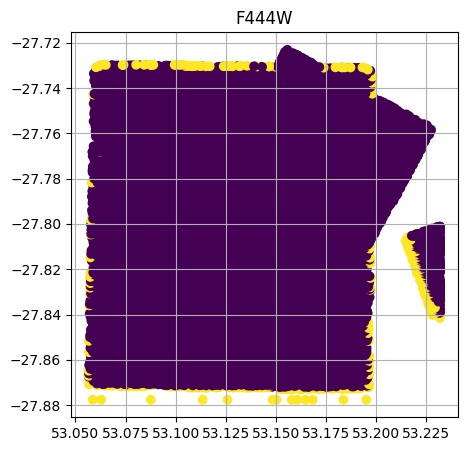

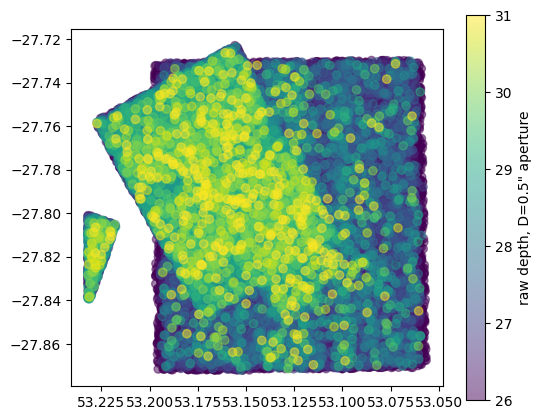

In [49]:
fig, ax = plt.subplots(1,1,figsize=(5,5), sharex=True, sharey=True)
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)

ax.scatter(phot['ra'], phot['dec'], c=phot['f444w-clear_flux_aper_1'].mask)
ax.set_title('F444W')

ax.set_aspect(1./cosd)
ax.grid()

# 5-sigma depth in the D=0.5" aperture
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)
depth = 23.9 - 2.5 * np.log10(phot['f444w-clear_flux_aper_1'] * 5)

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_aspect(1./cosd)
so = np.argsort(depth)
sc = ax.scatter(phot['ra'][so], phot['dec'][so], c=depth[so], vmin=26, vmax=31, alpha=0.5)

ax.set_xlim(*ax.get_xlim()[::-1])

cb = plt.colorbar(sc)
cb.set_label('raw depth, D=0.5" aperture')

### Point sources

## Catalog with aperture corrections

- `{filter}_corr_{aper} = {filter}_corr_{aper} * flux_auto / flux_{aper}` : Aperture corrected to the `auto` flux in the detection band
- `{filter}_tot_{aper} = {filter}_corr_{aper} * {filter}_tot_corr` : Corrected for flux outside of the auto aperture.  *Not implemented for JWST, where `corr = tot`*


In [50]:
if not os.path.exists(f'{field}-fix.photoz.tar.gz'):
    ! wget {url_path}/{field}-fix.photoz.tar.gz

! tar xzvf {field}-fix.photoz.tar.gz

gds-grizli-v7.0-fix.eazypy.h5
gds-grizli-v7.0-fix.eazypy.residuals.001.png
gds-grizli-v7.0-fix.eazypy.residuals.002.png
gds-grizli-v7.0-fix.eazypy.residuals.003.png
gds-grizli-v7.0-fix.eazypy.zout.fits
gds-grizli-v7.0-fix.eazypy.zphot.param
gds-grizli-v7.0-fix.eazypy.zphot.translate
gds-grizli-v7.0-fix.eazypy.zphot.zeropoint
gds-grizli-v7.0-fix.zhist.png
._gds-grizli-v7.0-fix.zphot_zspec.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
gds-grizli-v7.0-fix.zphot_zspec.png
gds-grizli-v7.0-fix_phot_apcorr.fits


In [51]:
apc = utils.read_catalog(f'{field}-fix_phot_apcorr.fits')

aper_index = '1'

cols = []

for k in apc.colnames:
    if k.startswith('f444w') & k.endswith(aper_index):
        cols.append(k)

apc[cols].info()

<GTable length=52427>
        name          dtype  unit    class     n_bad
-------------------- ------- ---- ------------ -----
   f444w_flux_aper_1 float64  uJy MaskedColumn   640
f444w_fluxerr_aper_1 float64  uJy MaskedColumn   640
   f444w_flag_aper_1   int16      MaskedColumn     0
    f444w_bkg_aper_1 float64  uJy MaskedColumn   641
   f444w_mask_aper_1 float64            Column     0
        f444w_corr_1 float64  uJy       Column     0
       f444w_ecorr_1 float64  uJy       Column     0
         f444w_tot_1 float64  uJy       Column     0
        f444w_etot_1 float64  uJy       Column     0


# Photometric redshifts

In [52]:
import eazy.hdf5

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')
self.fit_phoenix_stars()

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

cloning https://github.com/gbrammer/eazy-photoz.git to /usr/local/lib/python3.10/dist-packages/eazy/data/
/usr/local/lib/python3.10/dist-packages/eazy/data/templates -> ./templates
/usr/local/lib/python3.10/dist-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /usr/local/lib/python3.10/dist-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 52427
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f110w_tot_1 f110w_etot_1 (241): hst/wfc3/IR/f110w.dat
f115w_tot_1 f115w_etot_1 (364): jwst_nircam_f115w
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f150wn_tot_1 f150wn_etot_1 (310): niriss-f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f182m_tot_1 f182m_etot_1 (370): jwst_nircam_f182m
f200w_tot_1 f200w

294it [00:11, 25.89it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 78.7 s (n_proc=1,  NOBJ=51146)
Fetch https://erda.ku.dk/vgrid/Gabriel%20Brammer/CONF//bt-settl_t400-7000_g4.5.fits


## Adjusted zeropoints

The iterated eazy "zeropoint" adjustments are used as a crude PSF-matching correction for the simple aperture photometry catalogs.  That is, all photometry is done on the native images and corrected to "total" using a single correction derived in the detection band.  The encircled energy (for point sources) will be different for the different instruments / filters, and the `eazy` zeropoint adjustments are initialized with corrections that would be appropriate to put point sources on a common scale.  Corrections to that are then derived based on the photo-z fits to the full catalog.

In [53]:
print('# ix filt f_number zp')
for i in np.argsort(self.lc):
    print(f"{i:2} {self.flux_columns[i].split('_')[0]:12} {self.f_numbers[i]:3} {self.zp[i]:.3f}")

# ix filt f_number zp
19 f435w        233 0.977
22 f475w        234 0.938
25 f606wu       214 0.851
24 f606w        236 0.849
26 f775w        238 0.798
27 f814w        239 0.783
28 f814wu       217 0.821
 0 f090w        363 0.877
29 f850lp       240 0.793
 1 f105w        202 0.856
 4 f115wn       309 0.805
 2 f110w        241 0.867
 3 f115w        364 0.815
 5 f125w        203 0.868
 6 f140w        204 0.886
 8 f150wn       310 0.815
 7 f150w        365 0.807
 9 f160w        205 0.895
10 f182m        370 0.841
11 f200w        366 0.838
12 f200wn       311 0.817
13 f210m        371 0.861
14 f277w        375 0.920
15 f335m        381 0.963
16 f356w        376 0.980
17 f410m        383 1.000
18 f430m        384 1.030
20 f444w        377 1.000
21 f460m        385 1.067
23 f480m        386 1.094


Text(0.5, 1.0, 'JWST gds-grizli-v7.0')

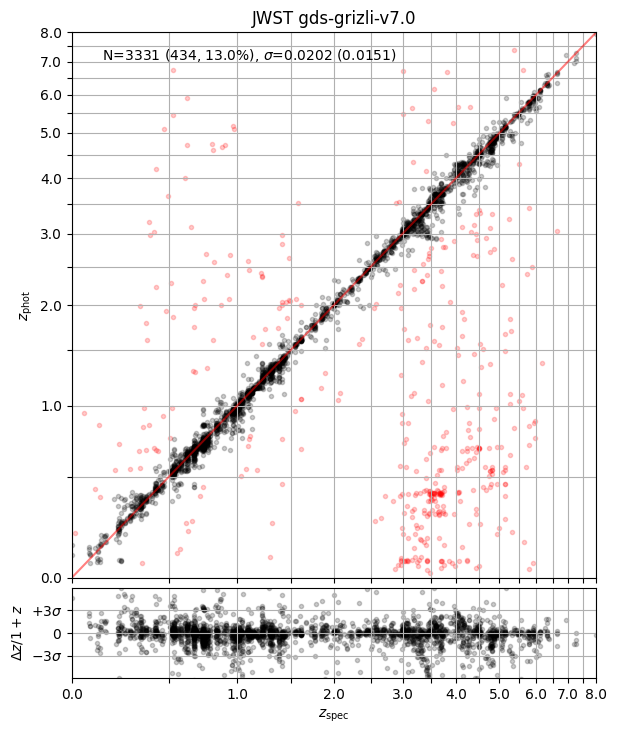

In [54]:
fig = eazy.utils.zphot_zspec(zout['z_phot'], zout['z_spec'], zmax=8)
fig.axes[0].set_title(f'JWST {field}')


## Plot some SEDs

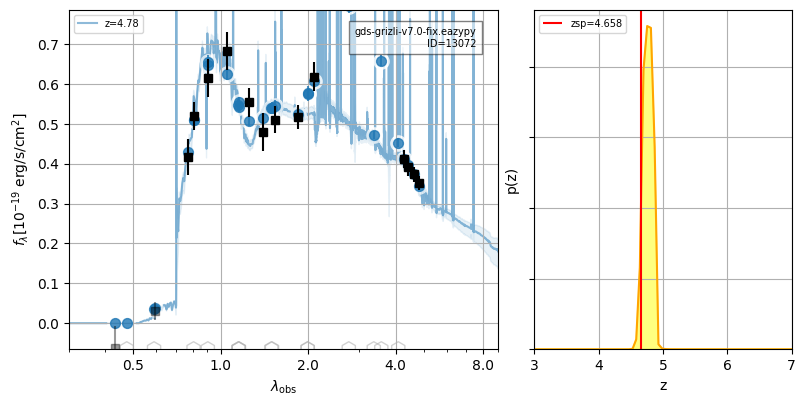

In [56]:
# e.g., GOODS-S-9209 from Carnall et al. https://arxiv.org/pdf/2301.11413.pdf
ra, dec = 53.1082274, -27.8252019

dr = np.sqrt((zout['ra'] - ra)**2 + (zout['dec'] - dec)**2)
self.cat['z_spec'][np.argmin(dr)] = 4.6582
cat_id = zout['id'][np.argmin(dr)]
_ = self.show_fit(cat_id, zr=[3,7],show_components=False)

53.108211,-27.825183
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/gds/jwst.html?coord=53.108211,-27.825183&zoom=6


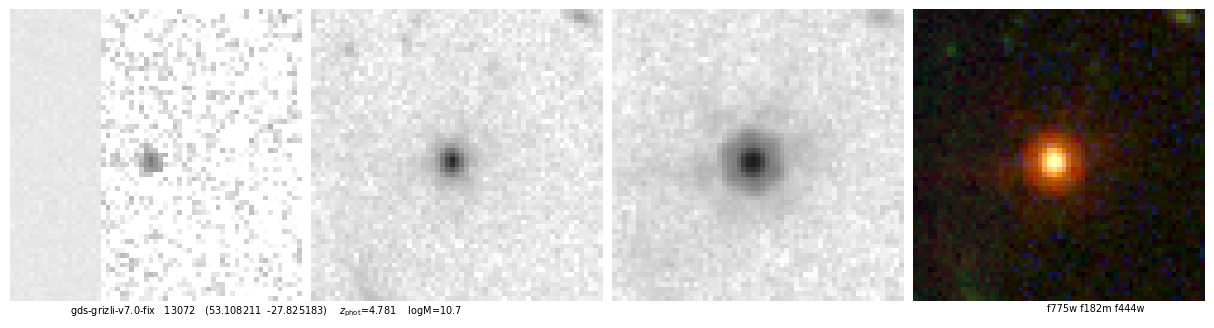

In [57]:
def quick_cutout(resp, sy=2, pl=2, size=1.5, scl=3, filters='f115w-clear,f277w-clear,f444w-clear'):
    """
    Make a cutout figure with the grizli cutout server
    """
    from PIL import Image
    import requests
    from io import BytesIO

    #rd = ds9.get('pan icrs').replace(' ',',')

    if isinstance(resp, int):
        id = resp
        ix = np.where(self.cat['id'] == id)[0][0]
    else:
        ix = resp['ix']
        id = resp['id']

    rd = f"{self.RA[ix]:.6f},{self.DEC[ix]:.6f}"


    print(rd)
    print(f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/gds/jwst.html?coord={rd}&zoom=6")

    url=f"https://grizli-cutout.herokuapp.com/thumb?coord={rd}&all_filters=True&size={size}&scl={scl}&asinh=True&filters={filters}&rgb_scl=1.0,0.95,1.2&pl={pl}"

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.apply_transparency()

    fig, ax = plt.subplots(1,1, figsize=(sy*4, sy+0.2), sharex=True, sharey=True)
    data = np.array(img)
    black = data.max(axis=2) == 0
    for ioff in range(-2,3):
        black &= np.roll(black, ioff, axis=0)


    for i in range(3):
        data[:,:,i][black] = 255

    ax.imshow(data, interpolation='Nearest', origin='upper')

    #ax.text(0.5, 0.01, 'nrc', color='r', fontsize=8, ha='center',va='bottom',transform=ax.transAxes)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    ax.text(0.05, -0.01, f"{root}   {self.cat['id'][ix]}   ({rd.replace(',','  ')})    z_phot={self.zbest[ix]:.3f}    logM={np.log10(zout['mass'][ix]):.1f}".replace('z_phot', r'$z_\mathrm{phot}$'),
            ha='left', va='top', transform=ax.transAxes, fontsize=7)

    ax.text(0.95, -0.01, filters.replace('-clear','').replace(',', ' '), ha='right', va='top',
            fontsize=7, color='k', transform=ax.transAxes)

    fig.tight_layout(pad=0.2)

    return id, fig, img

if 1:
    id, fig, img = quick_cutout(_[1], pl=2, scl=4, sy=3, filters='f775w,f182m-clear,f444w-clear')

# id, fig, img = quick_cutout(_[1], pl=2, scl=5, sy=3)


## find your own galaxy in Abell2744 (note different field from earlier)

plug in the ra, dec coordinates from the url header, and then show the sed and image stamps (see lecture note example)

In [68]:
# this is the field name
field = 'abell2744clu-grizli-v7.1'
if not os.path.exists(f'{field}-fix.photoz.tar.gz'):
    ! wget {url_path}/{field}-fix.photoz.tar.gz

! tar xzvf {field}-fix.photoz.tar.gz
root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')
self.fit_phoenix_stars()

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat


--2024-08-09 14:52:39--  https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/abell2744clu-grizli-v7.1-fix.photoz.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.80.254, 16.182.99.168, 52.216.154.246, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.80.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244425402 (233M) [application/x-tar]
Saving to: ‘abell2744clu-grizli-v7.1-fix.photoz.tar.gz’

abell2744clu-grizli 100%[===================>] 233.10M  25.3MB/s    in 9.2s    

2024-08-09 14:52:49 (25.3 MB/s) - ‘abell2744clu-grizli-v7.1-fix.photoz.tar.gz’ saved [244425402/244425402]

abell2744clu-grizli-v7.1-fix.eazypy.h5
abell2744clu-grizli-v7.1-fix.eazypy.residuals.001.png
abell2744clu-grizli-v7.1-fix.eazypy.residuals.002.png
abell2744clu-grizli-v7.1-fix.eazypy.residuals.003.png
abell2744clu-grizli-v7.1-fix.eazypy.zout.fits
abell2744clu-grizli-v7.1-fix.eazypy.zphot.param
abell2744clu-grizli-v7.1-fix.eazypy.zphot.translate
abell2744clu-gr

294it [00:15, 19.34it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 88.5 s (n_proc=1,  NOBJ=52589)
phoenix_templates: ./bt-settl_t400-7000_g4.5.fits


3.538856,-30.362270
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/gds/jwst.html?coord=3.538856,-30.362270&zoom=6


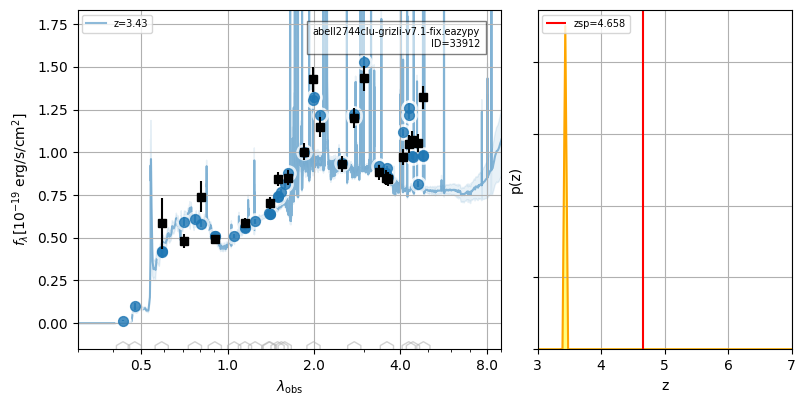

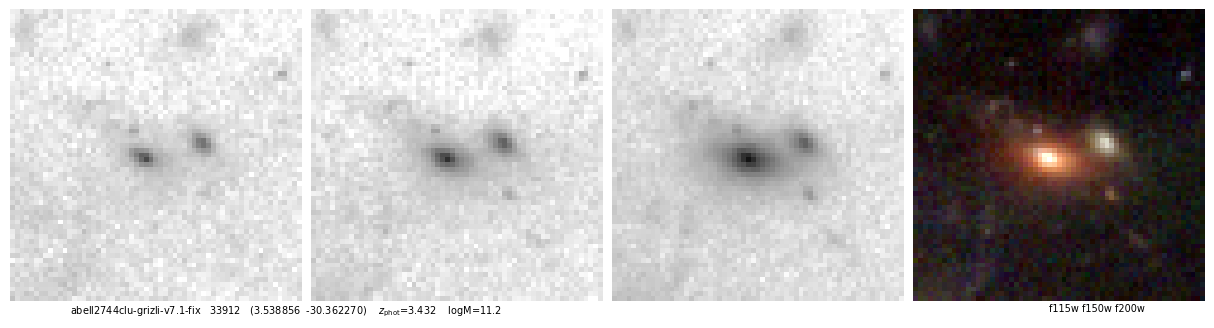

In [69]:
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u

# green emission line galaxy
#ra, dec = 3.5368242,-30.3614348

# red galaxy
ra, dec = 3.5388144,-30.3622799

dr = np.sqrt((zout['ra'] - ra)**2 + (zout['dec'] - dec)**2)
self.cat['z_spec'][np.argmin(dr)] = 4.6582
cat_id = zout['id'][np.argmin(dr)]
_ = self.show_fit(cat_id, zr=[3,7],show_components=False)
id, fig, img = quick_cutout(_[1], pl=2, scl=4, sy=3, filters='f115w-clear,f150w-clear,f200w-clear')